# Extracting and Transforming Citi Bike Data for Analysis 
## How is Citi Bike availability affected by various factors like time of day and weather?

### Who:
I am [Alhan Keser](https://blog.alhan.co/), a [10+ year specialist in Web Experimentation](https://www.linkedin.com/in/alhankeser/) (aka A/B Testing, Conversion Optimization), on my way to a Master's in Data Science.

### What:
This is an original analysis of Citi Bike station data from May-June 2019 to find out what affect the day of week, time of day, and weather (temperature, precipitation, etc...) have on the availability of bikes at station-,  neighborhood-, and borough-levels. 

### Why:
- I wanted to push myself to extract and transform my own data. Skipping the entire ETL process and going straight into analysis is a luxury: it does not reflect reality. 
- Doing a time-series analysis is something that I wanted practice with. 
- I commute by bike every day (despite weather) so I have first-hand evidence that Citi Bike riders tend to shy away from biking in inclement weather. It will be interesting to visualize the differences here.   

### How:
- **Combined original data sources:**
    - [Citi Bike Live Station Status](https://feeds.citibikenyc.com/stations/stations.json)
    - [Dark Sky Weather API](https://darksky.net/dev/docs)
    - [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro)
- **Created cron jobs** to collect Citi Bike station statuses for all ~858 stations, every 3 minutes, for ~2 months.
    - Total rows in final table: 5,800,274
    - "Why stop after 2 months," you ask? Because my server ran out of space while I was on vacation. Here's what that looks like: 

![My server crashed July 14](https://blog.alhan.co/storage/images/posts/2/web-server-crashed_2_1568434613_sm.jpg)
- **Created a mini-ETL process** to transform data into the final output used below. 
    - Along the way, there were many errors, some of which I will resolve here.

### Table of Contents
- [Packages](#Packages)
- [Extracting](#Extracting)
    - [Stations-Raw](#Stations-Raw)
    - [Stations-Flat](#Stations-Flat)
    - [Geocoding](#Geocoding)
    - [Weather](#Weather)
    - [Cron Jobs](#Cron-Jobs)
- [Transforming](#Transforming)
    - [Availability by Station](#Availability-by-Station)
- [Cleaning](#Cleaning)
    - [Reducing Complexity](#Reducing-Complexity)
    - [Data Quality Issues](#Data-Quality-Issues)
    - [Fixing Zip Data Type](#Fixing-the-zip-data_type-issue)
    - [Fixing Missing Weather](#Fixing-the-missing-weather-issue)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Hypotheses](#Hypotheses)

### Packages
Importing a few packages that will help with describing, cleaning and visualizing things. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from darksky import forecast
import random
import warnings
import time
from datetime import datetime as dt
from dateutil.parser import parse
from dotenv import load_dotenv
import os
load_dotenv()
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Extracting
I started by find an interesting data source. In this case, I found the [Citi Bike Station Feed](https://feeds.citibikenyc.com/stations/stations.json) via the [NYC Open Data site](https://opendata.cityofnewyork.us/).

The feed shows the latest statuses of ~858 Citi Bike stations. Below is a list of values per station and sample data for each. Any keys left blank are often blank in the data source as well, which I'll address in later steps. 

| key | sample value |
|------------:|:---------|
| `id`        | 285|
| `stationName` |"Broadway & E 14St"|
| `availableDocks` |20|
| `totalDocks` |53|
| `latitude`|40.73454567|
| `longitude`   |-73.99074142|
| `statusValue` |"In Service"|
| `statusKey`   |1|
| `availableBikes` |31|
| `stAddress1`  |"Broadway & E 14 St"|
| `stAddress2`  |""|
| `city`        |""|
| `postalCode`  |""|
| `location`    |""|
| `altitude`    |""|
| `testStation` |false|
| `lastCommunicationTime` |"2019-09-12 08:38:21 PM"|
| `landMark`    |""|

#### Stations-Raw

To have a back-up in case any of the subsequent steps went awry, I wanted to store the source data in the simplest way possible: a table `stations_raw` that stored the following: 

|column_name|data_type|sample value|
|-----------|-----------|----------|
|id         |int4|31419|
|status     |json|{"executionTime": "2019-06-22 01:53:41 PM", "s...|

Once the table created, I needed a way to collect data. A quick solution -- for me -- was to create [a Laravel application](https://github.com/alhankeser/citibike-tracker/)  that [makes it easy create console commands](https://laravel.com/docs/5.8/artisan#writing-commands). In combination with [Laravel Forge](https://forge.laravel.com), it's easy to set up a cron job that triggers [the necessary command](https://github.com/alhankeser/citibike-tracker/blob/d61f82adde88c90430205785297abf9f3de07c4d/app/Console/Kernel.php#L49) at set intervals.

Once the commands created, I set up a [cron job](#Cron-Jobs) that ran once every 3 minutes. This resulted in the collection of 41,325 rows.

#### Stations-Flat
As part of the same command that creates the [stations_raw](#Stations-Raw) table, I [flattened out the JSON](https://github.com/alhankeser/citibike-tracker/blob/d61f82adde88c90430205785297abf9f3de07c4d/app/Console/Kernel.php#L80) and created a table with a single row per 3-minute interval, per station. We'll call this table `stations_flat` (probably could have used a better naming convention throughout this project). 

Here is the structure of `stations_flat` and some sample data:

|column_name|data_type|sample value|description|
|-----------|---------|------------|-----------|
|id         |int4     |10511778    |row id|
|station_id |int4     |72          |unique id for each station|
|available_bikes|int4 |4           |number of available bikes at the station|
|available_docks|int4 |49          |number of available docks (places to park a bike) at the station|
|station_status|text  |In Service  |whether the station is in or out of service|
|last_communication_time|timestamp|2019-05-15 01:14:15|the last time the station sent back data|

After just over 2 months of this, I ended up with **34,301,048 rows** in this table. Luckily, I took some steps to make the volume of data more manageable when analyzing outside of a high CPU/RAM environment. 

#### Stations-Static
As the name suggests, `stations_static` contains information about each station that doesn't change minute-to-minute. Since there was a likelihood that stations be added, removed, renamed, I inserted or updated on duplicate each time `stations_flat` was updated. 

|column_name|data_type|sample value|description|
|-----------|---------|------------|-----------|
|id| int4|3119|unique `station_id` found throughout db|
|name| text|Vernon Blvd & 50 Ave||
|latitude |float8|40.74232744||
|longitude |float8|-73.95411749||
|status_key| int4|1||
|postal_code| text|NULL||
|st_address_1| text|Vernon Blvd & 50 Ave||
|st_address_2| text|NULL||
|total_docks| int4|45||
|status| text|In Service||
|altitude| text|NULL||
|location| text|NULL||
|land_mark| text|NULL||
|city| text|NULL||
|is_test_station| int4|0||

#### Geocoding
As can be seen from the `stations_static` table above, many of the location-related values are null. This was the case for all stations. I wanted to be able to group stations by neighborhood and zip. Also, I wanted to use zip to associate weather data to each station, without having to make separate requests for each station (to stay within the free tier of the [Dark Sky Weather API](https://darksky.net/dev/docs)). 

To geocode from lat/long for each station into human-readeable location info, I used the [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/intro). [See the command I used to create the below table](https://github.com/alhankeser/citibike-tracker/blob/d61f82adde88c90430205785297abf9f3de07c4d/app/Console/Kernel.php#L92)

|column_name|data_type|sample value|description|
|-----------|---------|------------|-----------|
|id|int4|1||
|station_id|int4|3119|unique station id|
|zip|text|11101|zip code of station|
|hood_1|text|LIC|neighborhood or the closest thing provided by Google|
|hood_2|text|Hunters Point|another level of neighborhood|
|borough|text|Queens|one of 5 NYC boroughs or New Jersey|

#### Weather
Grouping stations by zip, I then called the [Dark Sky Weather API](https://darksky.net/dev/docs) once every hour to build the `weather` table. Reducing the scope to zip made it possible to stay within the free plan limits of Dark Sky. 

|column_name|data_type|sample value|description|
|-----------|---------|------------|-----------|
|id|int4|1||
|time_interval|timestamptz|2019-05-02 01:00:00-04|the 15-minute interval of time to associate the weather data to|
|summary|text|Foggy|a categorical label for weather conditions|
|precip_intensity|float8|0|percent percipitation intensity|
|temperature|float8|61.45|temperature in Fahrenheit|
|apparent_temperature|float8|61.89|"feels-like" temperature|
|dew_point|float8|60.82||
|humidity|float8|0.98|percent humidity|
|wind_speed|float8|3.11|speed in MPH|
|wind_gust|float8|5.38|gusts in MPH|
|cloud_cover|float8|1|percent cloud cover|
|uv_index|float8|0||
|visibility|float8|3.18||
|ozone|float8|316.23||
|status|text|observed|one of two values ("predicted"/"observed") depending on if the weather values are from the past or the future|

#### Cron Jobs
I'm not going to spend a lot of time on discussing cron jobs, but here are the patterns I was using to run everything. There is probably a more optimal approach that I am not aware of. 

|Cron       |Command|
|-----------|-------|
|\*/3 \* \* \* \* | get:docks && update:availability 0 && update:weather|
|0 \*/2 \* \* \*  | get:weather 0|

View the code behind each command:
- `get:docks` [view](https://github.com/alhankeser/citibike-tracker/blob/d61f82adde88c90430205785297abf9f3de07c4d/app/Console/Kernel.php#L49)
- `update:availability 0` [view](https://github.com/alhankeser/citibike-tracker/blob/d61f82adde88c90430205785297abf9f3de07c4d/app/Console/Kernel.php#L179)
- `update:weather` [view](https://github.com/alhankeser/citibike-tracker/blob/d61f82adde88c90430205785297abf9f3de07c4d/app/Console/Kernel.php#L359)
- `get:weather 0` [view](https://github.com/alhankeser/citibike-tracker/blob/d61f82adde88c90430205785297abf9f3de07c4d/app/Console/Kernel.php#L276)

### Transforming
Once I had the 1 raw table and 4 tables above updating as expected, I created a single, flat table that had the final data I intended to use for analysis. I kept most columns except some of the minutiae of the `weather` table. This table was updated regularly such that I could run analyses on an on-going basis and avoid having to run a massive, single query after all data had been collected.   

#### Availability by Station
Below is the flat table `availability` that combined the above tables, purpose-built for analysis. Note that available_bikes is the minimum number of bikes available during any of the 3-minute intervals during which samples were collected over the course of each 15-minute interval. 

|column_name|data_type|
|-----------|---------|
|time_interval|timestamptz|
|station_id|int4|
|station_name|text|
|station_status|text|
|latitude|float8|
|longitude|float8|
|zip|text|
|borough|text|
|hood|text|
|available_bikes|int4|
|available_docks|int4|
|weather_summary|text|
|precip_intensity|float8|
|temperature|float8|
|humidity|float8|
|wind_speed|float8|
|wind_gust|float8|
|cloud_cover|float8|
|weather_status|text|
|created_at|timestamptz|
|updated_at|timestamptz|

### Cleaning

#### Reducing Complexity
First things first, I wanted to reduce the number of stations I was analyzing. The `availability` table resulted in nearly 6 million rows after 2 months, so I decided to export a subset of "interesting" stations to begin analyzing. Below is the query I used to find the interesting stations, based on whether there is a high variability in number of bikes, that the bikes regularly get refilled, and that the station has a decent number of bikes. I also limited the number of stations per neighborhood to 1.  
https://gist.github.com/alhankeser/9fbaf67a8ce052de72f22ab1630cd91c

```sql
with variability as (
    select
		borough,
		hood,
		station_name,
		station_id,
		max(available_bikes) as max_bikes,
		sum(case when available_bikes = 0 then 1 else 0 end) as times_no_bikes,
		sum(case when available_docks = 0 then 1 else 0 end) as times_replenished
	from 
		availability
	where
		station_status = 'In Service'
	group by
		station_id, station_name, hood, borough
),
percentiles as ( 
	select
		*,
        ntile(100) over (order by max_bikes asc) max_bikes_percentile,
		ntile(100) over (order by times_no_bikes asc) no_bikes_percentile,
	 	ntile(100) over (order by times_replenished asc) times_replenished_percentile
	from
		variability
	order by times_no_bikes
),
ranks as (
	select
		*,
		(max_bikes_percentile + no_bikes_percentile + times_replenished_percentile) as score,
		rank() over (partition by hood order by (max_bikes_percentile + no_bikes_percentile + times_replenished_percentile) desc) as rank
	from 
		percentiles
	where
		max_bikes_percentile > 40 
		and no_bikes_percentile > 50
		and times_replenished_percentile > 50
),
ranked_by_hood as (
	select
		*
	from 
		ranks
	where
		rank = 1 
	order by
		score desc
)
select
	a.*
from
	availability as a
join 
	ranked_by_hood as rbh 
	on a.station_id = rbh.station_id;
```

The query above reduced the nearly 6 million rows down to 186,000. The csv export used for the analysis below can be [found here](https://github.com/alhankeser/citibike-analysis/blob/master/input/availability_interesting_original.csv). 

#### Data Quality Issues
As can be seen below, without much digging, it's easy to spot some data quality/consistency issues: 
1. `zip` is being converted to an integer and thus dropping the 0, which is may or may not be an issue. If wish to solve problem #1 then this chould be an issue. 
1. `weather_status` should be 'observed' for all locations rather than 'predicted' since the dates are in the past. 

In [30]:
date_cols = ['time_interval', 'updated_at', 'created_at']
df = pd.read_csv('../input/availability_interesting_original.csv', parse_dates=date_cols)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186030 entries, 0 to 186029
Data columns (total 21 columns):
station_id          186030 non-null int64
station_name        186030 non-null object
station_status      186030 non-null object
latitude            186030 non-null float64
longitude           186030 non-null float64
zip                 186030 non-null int64
borough             186030 non-null object
hood                186030 non-null object
available_bikes     186030 non-null int64
available_docks     186030 non-null int64
time_interval       186030 non-null datetime64[ns]
created_at          186030 non-null datetime64[ns]
weather_summary     88053 non-null object
precip_intensity    88053 non-null float64
temperature         88053 non-null float64
humidity            88053 non-null float64
wind_speed          88053 non-null float64
wind_gust           88053 non-null float64
cloud_cover         88053 non-null float64
weather_status      88053 non-null object
updated_at       

In [42]:
print(df.head(3)) #printing to improve how this looks in the README.md markdown file

   station_id station_name station_status   latitude  longitude   zip  \
0        3195      Sip Ave     In Service  40.730897 -74.063913  7306   
1        3195      Sip Ave     In Service  40.730897 -74.063913  7306   
2        3195      Sip Ave     In Service  40.730897 -74.063913  7306   

      borough            hood  available_bikes  available_docks  \
0  New Jersey  Journal Square                1               33   
1  New Jersey  Journal Square                0               34   
2  New Jersey  Journal Square                0               34   

        time_interval          created_at weather_summary  precip_intensity  \
0 2019-05-13 02:45:00 2019-05-13 02:45:04        Overcast               0.0   
1 2019-05-13 02:30:00 2019-05-13 02:30:04        Overcast               0.0   
2 2019-05-13 02:15:00 2019-05-13 02:15:05        Overcast               0.0   

   temperature  humidity  wind_speed  wind_gust  cloud_cover weather_status  \
0        44.86      0.91        6.85      

#### Fixing the zip data_type issue
The issue related to zip codes is related to New Jersey's that start with a zero. There are two options to fix this:  
1. Mutate the existing column to a string and insert a 0 to the beginning of the incorrect zip.  
OR  
2. Read the csv with dtype specified as `str` for the `zip` column. 

Going to go with option #2 and re-import the csv correctly, then check that `zip` is in fact treated as a string:

In [2]:
date_cols = ['time_interval', 'updated_at', 'created_at']
data_types = {'zip': str}
df = pd.read_csv('../input/availability_interesting_original.csv', parse_dates=date_cols, dtype=data_types)

In [13]:
df['zip'].dtype

dtype('O')

#### Fixing the missing weather issue
As for why weather_status is not set to 'observed', which would mean that the weather data my be inaccurate (since only the predicted weather was captured), I will need to first measure the extent of the problem, then remedy by fetching the correct weather data.

First, let's get an understanding of the rows affected: 

In [214]:
print(df['weather_status'].unique())

['predicted' 'observed' nan]


In [68]:
print('Weather Status: ')
print(df[df['weather_status'] == 'predicted'].count()[0], str(round(df[df['weather_status'] == 'predicted'].count()[0]/df.count()[0]*100)) + '%' , ' Predicted')
print(df[df['weather_status'] == 'observed'].count()[0], str(round(df[df['weather_status'] == 'observed'].count()[0]/df.count()[0]*100)) + '%', ' Observed')
print(df[df['weather_status'].isna()].count()[0], str(round(df[df['weather_status'].isna()].count()[0]/df.count()[0]*100)) + '%'' NAs')

Weather Status: 
6448 3.0%  Predicted
81605 44.0%  Observed
97977 53.0% NAs


It is apparent that there is a larger issue here: we have `nan` values in the `weather_status` column! Let's assume that there is no option to go back and re-run the original commands that fetched the weather data in the first place and that I will have to do this all here...

Let's see which stations are affected by the missing weather_status data: 

In [101]:
print(df[df['weather_status'].isna()]['hood'].unique())

['UES' 'Williamsburg' 'LIC' 'New York County' 'Yorkville' 'UWS'
 'Journal Square' 'Park Slope' 'Downtown Brooklyn' 'Chelsea'
 'Prospect Heights' 'Crown Heights' 'Lincoln Square' 'Alphabet City'
 'Canal Street' 'Financial District' 'Little Italy' 'Tribeca'
 'Ukrainian Village' 'Battery Park City' 'West Village' 'Clinton Hill'
 'Lower East Side' "Hell's Kitchen" 'Midtown East' 'Peter Cooper Village'
 'Stuyvesant Town-Peter Cooper Village']


In [100]:
print(df[df['weather_status'].isna()]['zip'].unique())

['10075' '11249' '11101' '10022' '10028' '10024' '07306' '11215' '11201'
 '10011' '11238' '10023' '10009' '10013' '10004' '10007' '10003' '10282'
 '10014' '11205' '10002' '10036' '10010']


In [102]:
print(len(df[df['weather_status'].isna()]['time_interval'].unique()))

4928


In [125]:
print('Start: ', df[df['weather_status'].isna()][['time_interval']].values[0])
print('Finish: ', df[df['weather_status'].isna()][['time_interval']].values[-1])

Start:  ['2019-05-21T11:45:00.000000000']
Finish:  ['2019-07-12T03:45:00.000000000']


I want to get weather data at the hour-level to keep things reasonable when fetching weather data, so I am going to round down the `time_interval` column:

In [3]:
df['time_hour'] = df['time_interval'].apply(lambda x: x.replace(microsecond=0, second=0, minute=0))

Looks like it worked as expected:

In [10]:
print(df[['zip', 'time_interval','time_hour']].head())

     zip       time_interval           time_hour
0  07306 2019-05-13 02:45:00 2019-05-13 02:00:00
1  07306 2019-05-13 02:30:00 2019-05-13 02:00:00
2  07306 2019-05-13 02:15:00 2019-05-13 02:00:00
3  07306 2019-05-13 02:00:00 2019-05-13 02:00:00
4  07306 2019-05-13 03:30:00 2019-05-13 03:00:00


Looking at the `nan`'s and `predicted`'s in `weather_status`, which are the unique `zip` and `time_hour` combinations that we'll need to re-fetch data for?

In [24]:
df_weather_na = df[(df['weather_status'].isna()) | (df['weather_status'] == 'predicted')][['zip','time_hour']].sort_values('time_hour').drop_duplicates()
print(df_weather_na.head())
print('Rows:', len(df_weather_na))

         zip           time_hour
0      07306 2019-05-13 02:00:00
12809  11101 2019-05-13 02:00:00
13452  11201 2019-05-13 02:00:00
887    10003 2019-05-13 02:00:00
5502   10013 2019-05-13 02:00:00
Rows: 22566


The way that the [Dark Sky Weather API](https://darksky.net/dev/docs) works is that you can fetch a whole day's worth of data for each location and it's considered one request. So rather than making an individual request for each zip and hour combination, I will be making a request for every zip and _day_ combination. Let's further reduce the granularity of the table...

In [25]:
df_weather_na['time_day'] = df_weather_na['time_hour'].apply(lambda x: x.replace(hour=0))
print(df_weather_na.head())
print('Rows:', len(df_weather_na))

         zip           time_hour   time_day
0      07306 2019-05-13 02:00:00 2019-05-13
12809  11101 2019-05-13 02:00:00 2019-05-13
13452  11201 2019-05-13 02:00:00 2019-05-13
887    10003 2019-05-13 02:00:00 2019-05-13
5502   10013 2019-05-13 02:00:00 2019-05-13
Rows: 22566


We don't need `time_hour`: 

In [26]:
df_weather_na.drop('time_hour', axis=1, inplace=True)
df_weather_na = df_weather_na.drop_duplicates()

In [186]:
print(df_weather_na.head())
print('Rows:', len(df_weather_na))

         zip   time_day
0      07306 2019-05-13
12809  11101 2019-05-13
13452  11201 2019-05-13
887    10003 2019-05-13
5502   10013 2019-05-13
Rows: 1422


To call the Dark Sky Weather API, we'll need to have sample lat/long coordinates to send. To do so, I will grab the coordinates of one station within each zip to represent that zip. 

In [23]:
df_weather_na['latitude'] = df_weather_na['zip'].apply(lambda x: df[df['zip'] == x]['latitude'].unique()[0])
df_weather_na['longitude'] = df_weather_na['zip'].apply(lambda x: df[df['zip'] == x]['longitude'].unique()[0])
print(df_weather_na.head())

         zip   time_day   latitude  longitude
0      07306 2019-05-13  40.730897 -74.063913
12809  11101 2019-05-13  40.742327 -73.954117
13452  11201 2019-05-13  40.692418 -73.989495
887    10003 2019-05-13  40.729538 -73.984267
5502   10013 2019-05-13  40.719105 -73.999733


Looking at what I did above, there's a less resource-intensive way to do that. First, by creating a table of zip to coordinate combinations: 

In [51]:
df_zip_coord = df[['zip','latitude', 'longitude']].drop_duplicates()
df_zip_coord['order'] = df_zip_coord.groupby('zip').latitude.rank(method='min')
print(df_zip_coord.sort_values('zip')[9:15])

        zip   latitude  longitude  order
5495  10013  40.719105 -73.999733    1.0
5499  10013  40.719392 -74.002472    2.0
7077  10014  40.736529 -74.006180    1.0
7640  10022  40.757148 -73.972078    1.0
7636  10022  40.763505 -73.971092    2.0
8960  10023  40.775160 -73.989187    1.0


In [52]:
df_zip_coord = df_zip_coord[df_zip_coord['order'] == 1]
df_zip_coord.drop('order', inplace=True, axis=1)
print(df_zip_coord.head())

        zip   latitude  longitude
0     07306  40.730897 -74.063913
224   10002  40.720664 -73.985180
886   10003  40.729538 -73.984267
1548  10004  40.703652 -74.011678
2210  10007  40.714979 -74.013012


1. Original method timing:

In [132]:
start_time_1 = time.process_time()
df_weather_na['latitude'] = df_weather_na['zip'].apply(lambda x: df[df['zip'] == x]['latitude'].unique()[0])
df_weather_na['longitude'] = df_weather_na['zip'].apply(lambda x: df[df['zip'] == x]['longitude'].unique()[0])
end_time_1 = time.process_time()
elapsed_time_1 = round(end_time_1 - start_time_1, 4)
print('Process Time Elapsed: ', elapsed_time_1)

Process Time Elapsed:  42.9605


2. Faster method timing (using lookup table):

In [19]:
start_time_2 = time.process_time()
df_weather_na['latitude'] = df_weather_na['zip'].apply(lambda x: df_zip_coord[df_zip_coord['zip'] == x]['latitude'].get_values()[0])
df_weather_na['longitude'] = df_weather_na['zip'].apply(lambda x: df_zip_coord[df_zip_coord['zip'] == x]['longitude'].get_values()[0])
end_time_2 = time.process_time()
elapsed_time_2 = round(end_time_2 - start_time_2, 4)
print('Process Time Elapsed: ', elapsed_time_2)

Process Time Elapsed:  2.028


3. And an even faster method, now that we have the lookup table, is to simply merge: 

In [29]:
start_time_3 = time.process_time()
df_weather_na = df_weather_na.merge(df_zip_coord, how='inner', on='zip')
end_time_3 = time.process_time()
elapsed_time_3 = round(end_time_3 - start_time_3, 4)
print('Process Time Elapsed: ', elapsed_time_3)

Process Time Elapsed:  0.0073


#### Re-fetching weather data
Now that we've reduced the number of individual requests we'll need to make to the [Dark Sky Weather API](https://darksky.net/dev/docs), we can start to setup the re-fetching process. 

Here is our dataset of missing weather: 

In [30]:
print(df_weather_na.head())
print(df_weather_na.shape)

     zip   time_day   latitude  longitude
0  07306 2019-05-13  40.730897 -74.063913
1  07306 2019-05-14  40.730897 -74.063913
2  07306 2019-05-15  40.730897 -74.063913
3  07306 2019-05-16  40.730897 -74.063913
4  07306 2019-05-17  40.730897 -74.063913
(1422, 4)


As a safety measure to avoid having to through these steps all over again, let's save this dataset to a csv:

In [149]:
df_weather_na.to_csv('../input/df_weather_na.csv', index=False)

Now on to creating a new DataFrame of correct weather data for the locations and days in `df_weather_na`, by hour. 

1. Get the api key:

In [33]:
try:
    ds_key = os.getenv("DARK_SKY_API_KEY")
except:
    pass

2. Create a function to build a DataFrame over time. Since I need to regulate how often I call the DS API within a 24h period, I created a set of functions to allow me to pick up where I leave off with no wasted API calls. After some trial and error, I've got it working below. Comments on each function provide more details. 

In [69]:
def get_weather_by_day(api_key, row):
    """Call the DarkSky API to request single day of weather and return a Forecast object"""
    day = dt.strftime(row.time_day, '%Y-%m-%dT%H:%M:%S')
    lat = row.latitude
    long = row.longitude
    weather = forecast(api_key, lat, long, time=day)
    return weather

def create_weather_df(zip_code, weather):
    """Create a DataFrame with the same columns and naming convention as primary df"""
    df_weather = pd.DataFrame(weather['hourly']['data'])
    df_weather.rename(columns={ 'precipIntensity': 'precip_intensity',
                                'windSpeed': 'wind_speed',
                                'windGust': 'wind_gust',
                                'cloudCover': 'cloud_cover',
                                'summary': 'weather_summary',
                                'time': 'time_hour'
                                }, inplace=True)
    df_weather = df_weather[['time_hour','precip_intensity','temperature',\
                             'humidity', 'wind_speed', 'wind_gust', \
                             'weather_summary', 'cloud_cover']]
    df_weather['time_hour'] = df_weather['time_hour'].apply(lambda x: dt.utcfromtimestamp(x-14400).strftime('%Y-%m-%d %H:%M:%S'))
    df_weather['time_hour'] = df_weather['time_hour'].apply(lambda x: parse(x))
    df_weather['zip'] = str(zip_code)
    df_weather['weather_status'] = 'observed'
    return df_weather

def get_start_index_df():
    """Get the latest version of the fixed weather df and the index on which to start"""
    try:
        df_weather_fix = pd.read_csv('../input/df_weather_fix.csv', dtype={'zip': str})
        df_weather_filtered = df_weather_na[(df_weather_na['zip'] == df_weather_fix.iloc[-24]['zip'])\
                                        & (df_weather_na['time_day'] == df_weather_fix.iloc[-24]['time_hour'])]
        return df_weather_fix, df_weather_filtered.index[0]+1
    except:
        df_weather_fix = pd.DataFrame(columns=['time_hour', 'precip_intensity',\
                                       'temperature', 'humidity',\
                                       'wind_speed', 'wind_gust',\
                                       'weather_summary', 'cloud_cover',\
                                       'zip', 'weather_status'])
        return df_weather_fix, 0
    
def get_weather_fix(ds_key, api_limit, df_weather_na):
    """Create an on-going df which contains missing weather data in increments as defined in api_limit"""
    df_weather_fix, start_index = get_start_index_df()
    api_limit = api_limit
    for index, row in df_weather_na[start_index:].iterrows():
        if index < (api_limit + start_index):
            weather = get_weather_by_day(ds_key, row)
            df_weather_day = create_weather_df(row['zip'], weather)
            df_weather_fix = df_weather_fix.append(df_weather_day)
        else:
            df_weather_fix.to_csv('../input/df_weather_fix.csv', index=False)
            print('Saved weather_fix to csv after', 'getting weather for', row['zip'], 'on', str(row['time_day']).split(' ')[0])
            break
        if index % 100 == 0:
            df_weather_fix.to_csv('../input/df_weather_fix.csv', index=False)
            print('Saved weather_fix to csv after', 'getting weather for', row['zip'], 'on', str(row['time_day']).split(' ')[0])
    print('DONE!')

In [ ]:
get_weather_fix(ds_key, 999, df_weather_na)

Successfully kept the total API requests to just below 1000 on Day 1:
![Dark Sky API Calls today](https://blog.alhan.co/storage/images/posts/2/dark-sky-api-calls_2_1569210787_md.jpg)

(And finished the remaining locations on Day 2)

#### Joining the fixed weather data
To avoid creating unnecessary columns by joining the fixed weather data to the entire df, I separate `df` into two:
- Observed
- NAs and Predicted (the dataset that needed joining with the fixed weather)

In [41]:
date_cols = ['time_interval', 'updated_at', 'created_at']
data_types = {'zip': str}
df = pd.read_csv('../input/availability_interesting_original.csv', parse_dates=date_cols, dtype=data_types)

df['time_hour'] = df['time_interval'].apply(lambda x: x.replace(microsecond=0, second=0, minute=0))

# Rows that are already clean and don't need changing:
df_weather_observed = df[df['weather_status'] == 'observed']

# Rows that need weather data corrected:
df_weather_na_predicted = df[(df['weather_status'].isna()) | (df['weather_status'] == 'predicted')]

# Removing the bad columns:
df_weather_na_predicted.drop(['precip_intensity', 'temperature', 'humidity',\
                              'wind_speed', 'wind_gust', 'weather_summary', \
                              'cloud_cover', 'weather_status'], axis=1, inplace=True)

# Getting the newly created fixed weather data:
df_weather_fix = pd.read_csv('../input/df_weather_fix.csv', dtype={'zip': str}, parse_dates=['time_hour'])

# Joining with the corrected weather data:
df_weather_fixed = df_weather_na_predicted.merge(df_weather_fix, how='left', on=['time_hour', 'zip'])

# Concatenating the already fixed weather rows with the newly fixed rows:
df_fixed = pd.concat([df_weather_observed, df_weather_fixed])
df_fixed = df_fixed.drop_duplicates()

# Quickly checking that it worked and that we didn't break anything:
print(df_weather_observed.info())
print(df_weather_fixed.info())
print(df_fixed.info())
print('NAs or Predicted:', len(df_fixed[(df_fixed['weather_status'].isna()) | (df_fixed['weather_status'] == 'predicted')].index))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 81605 entries, 72 to 186029
Data columns (total 22 columns):
station_id          81605 non-null int64
station_name        81605 non-null object
station_status      81605 non-null object
latitude            81605 non-null float64
longitude           81605 non-null float64
zip                 81605 non-null object
borough             81605 non-null object
hood                81605 non-null object
available_bikes     81605 non-null int64
available_docks     81605 non-null int64
time_interval       81605 non-null datetime64[ns]
created_at          81605 non-null datetime64[ns]
weather_summary     81605 non-null object
precip_intensity    81605 non-null float64
temperature         81605 non-null float64
humidity            81605 non-null float64
wind_speed          81605 non-null float64
wind_gust           81605 non-null float64
cloud_cover         81605 non-null float64
weather_status      81605 non-null object
updated_at          81605 no

Re-creating `df`, this time with fixed weather data:

In [42]:
df_fixed.to_csv('../input/availability_interesting_weather_fix.csv', index=False)

### Exploratory Data Analysis
On to the fun part. Now that I've got all of my station-by-station availability by 15-minute interval, it's time to explore. 

In [43]:
date_cols = ['time_interval', 'updated_at', 'created_at', 'time_hour']
data_types = {'zip': str}
df = pd.read_csv('../input/availability_interesting_weather_fix.csv', dtype={'zip': str}, parse_dates=date_cols)

#### Hypotheses

Below is a list of hypotheses, in no particular order, that may be interesting to validate in the following analysis:  
- If we categorize stations by 'residential', 'business', and 'touristic' we will see distinctly different availability patterns.
- On business days, rush hour traffic will significantly impact availability at 'residential' and 'business' stations, whereas 'touristic' stations will fluctuate throughout the day and may not have a repeating pattern.
- Stations deemed 'touristic' will be more affected by changes in weather than non-touristic stations. 
- Weekend, Holiday and Business Day availability patterns will be the most distinct for residential and business stations, whereas touristic stations will be less affected by type of day.
- On evenings where inclement weather (in form of rain) was observed, there will be an increase in morning usage of Citi Bikes (by individuals who own bicycles, but prefer to take a Citi Bike into work to avoid having to ride home in the rain). 
- On business days before and after a holiday, there may be a decrease in overall Citi Bike usage. Might be worth excluding these days entirely from the analysis as they do no represent business days or weekends. Luckily, we only have the 4th of July to deal with as part of this dataset. 


#### Other Notes
- When there is only one bike left at 'residential' or 'business' stations, it may not be a major issue, but it is a problem when it happens at stations classified as 'touristic', assuming that tourists are seldom alone. 

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186758 entries, 0 to 186757
Data columns (total 22 columns):
available_bikes     186758 non-null int64
available_docks     186758 non-null int64
borough             186758 non-null object
cloud_cover         186758 non-null float64
created_at          186758 non-null datetime64[ns]
hood                186758 non-null object
humidity            186758 non-null float64
latitude            186758 non-null float64
longitude           186758 non-null float64
precip_intensity    186758 non-null float64
station_id          186758 non-null int64
station_name        186758 non-null object
station_status      186758 non-null object
temperature         186758 non-null float64
time_hour           186758 non-null datetime64[ns]
time_interval       186758 non-null datetime64[ns]
updated_at          186758 non-null datetime64[ns]
weather_status      186758 non-null object
weather_summary     186758 non-null object
wind_gust           186758 non-null f

#### How does time of day effect Citi Bike availability?

Create time of day column:

In [47]:
df['hour'] = df['time_hour'].apply(lambda x: x.hour)

Visualize average availability by hour:

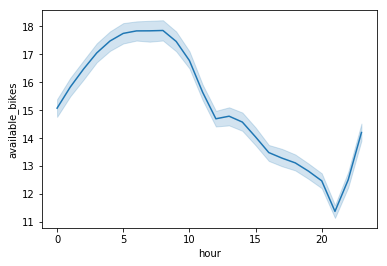

In [95]:
sns.lineplot(x=df['hour'], y=df['available_bikes'])

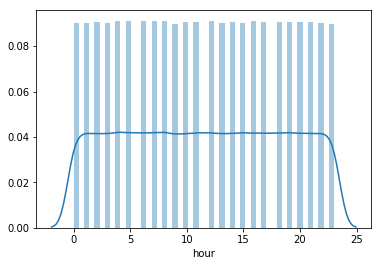

In [96]:
sns.distplot(df['hour'])

In [104]:
df['time'] = df['time_interval'].apply(lambda x: x.time())

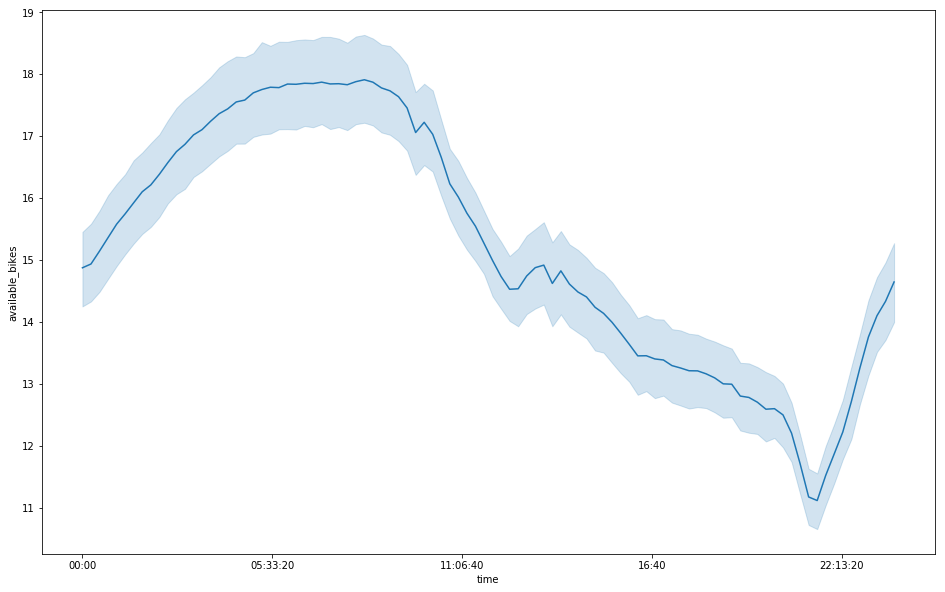

In [121]:
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x=df['time'], y=df['available_bikes'])

In [114]:
df['day'] = df['time_interval'].apply(lambda x: x.strftime('%A'))

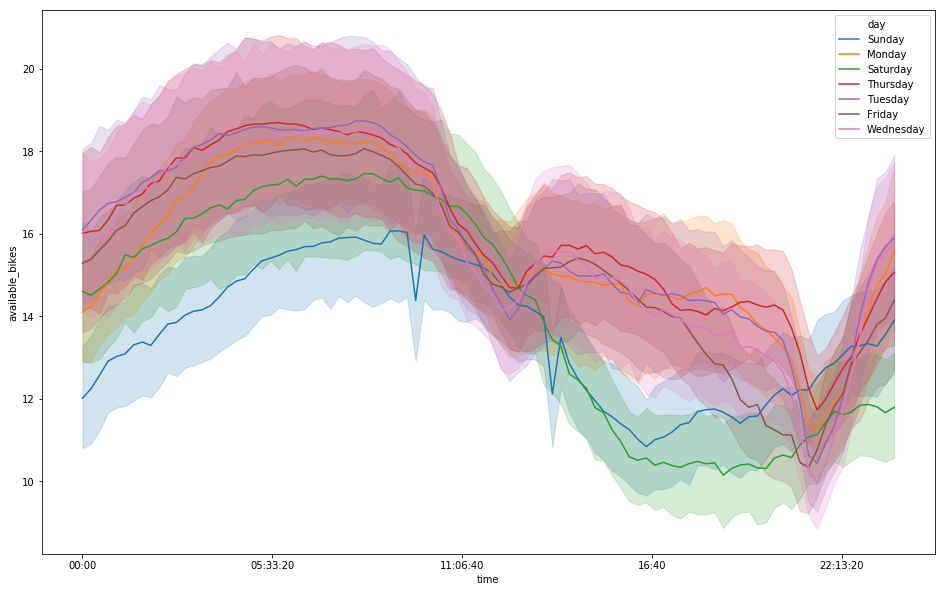

In [131]:
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x='time', y='available_bikes', data=df, hue='day')
plt.show()

In [123]:
def get_day_type(x):
    if x.weekday() > 4:
        return 'weekend'
    return 'weekday'

df['day_type'] = df['time_interval'].apply(lambda x: get_day_type(x))

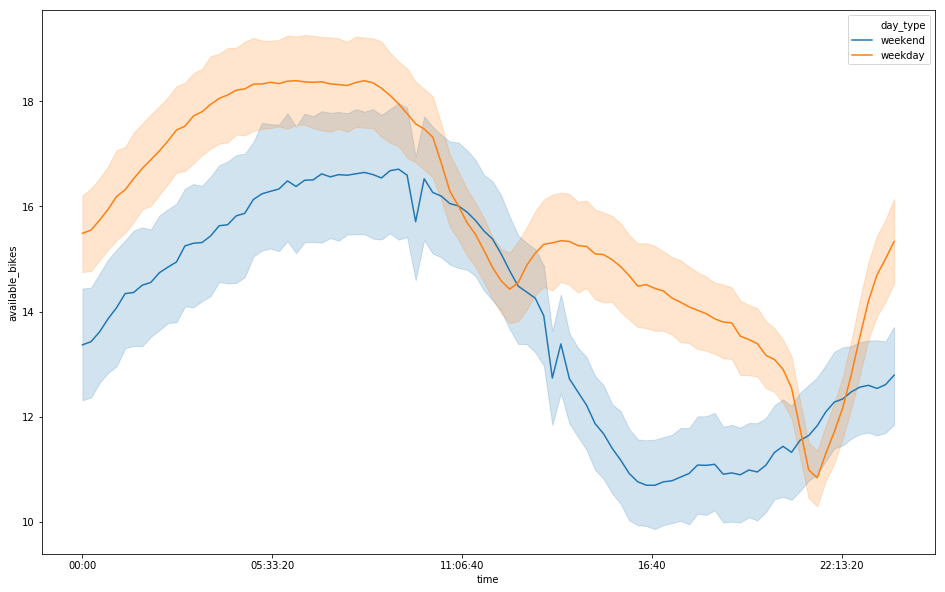

In [124]:
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x='time', y='available_bikes', data=df, hue='day_type')
plt.show()

Sip Ave


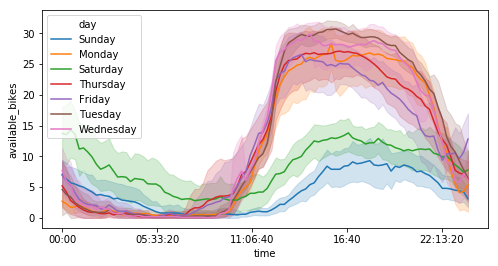

Suffolk St & Stanton St


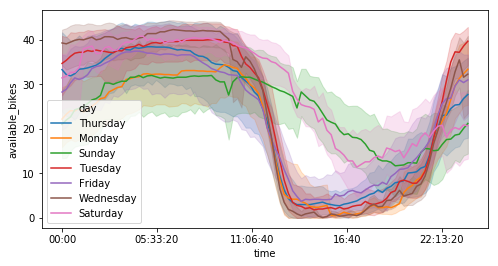

E 11 St & 1 Ave


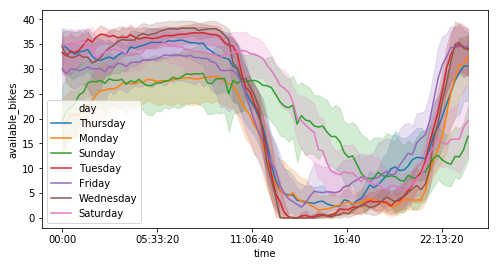

Broad St & Bridge St


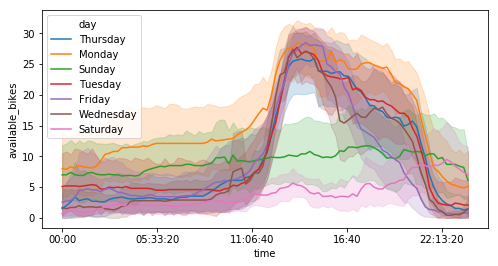

Murray St & West St


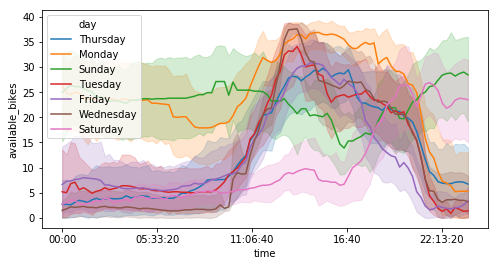

1 Ave & E 18 St


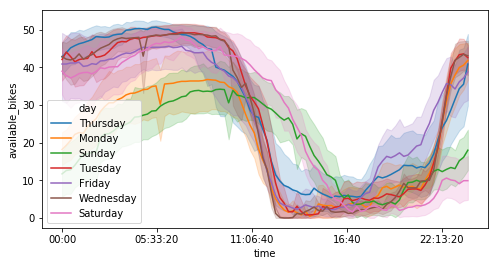

E 2 St & Avenue C


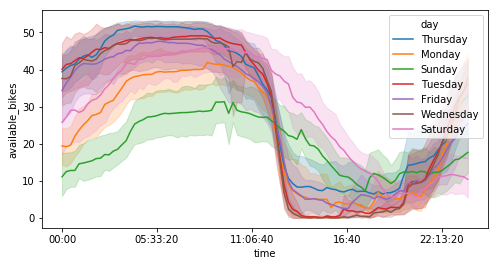

E 23 St & 1 Ave


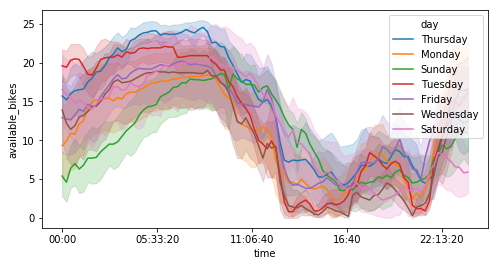

W 15 St & 10 Ave


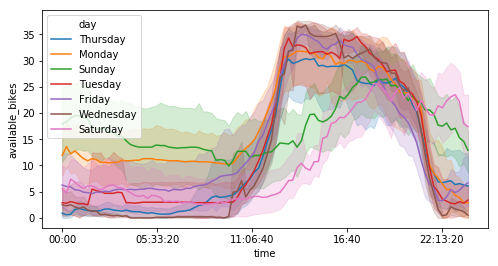

Howard St & Centre St


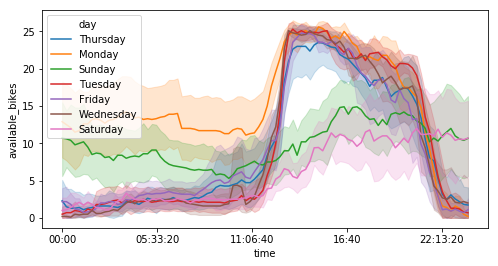

Lispenard St & Broadway


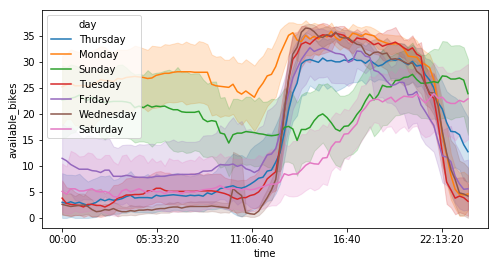

Bank St & Hudson St


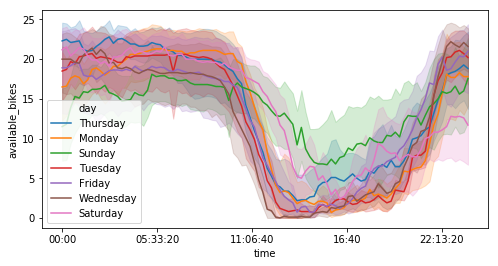

E 59 St & Madison Ave


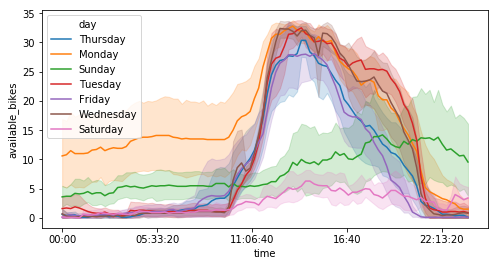

E 51 St & Lexington Ave


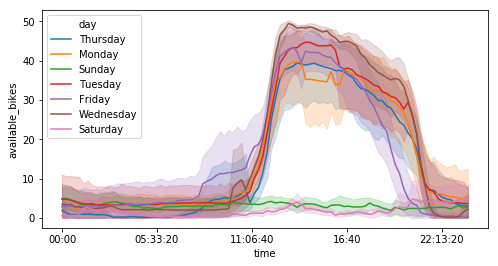

W 64 St & Thelonious Monk Circle


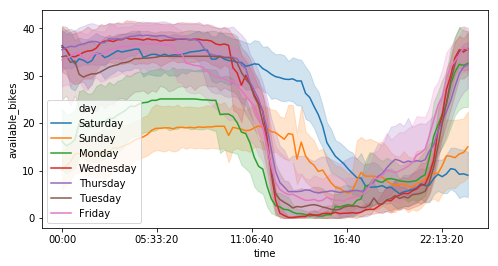

Riverside Dr & W 82 St


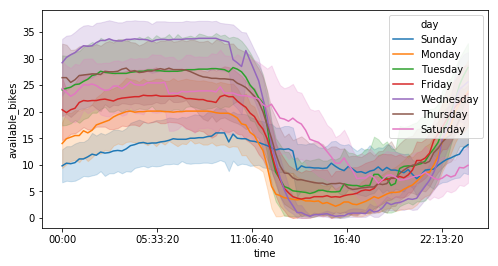

E 81 St & York Ave


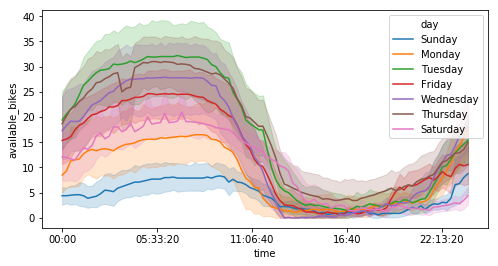

W 43 St & 10 Ave


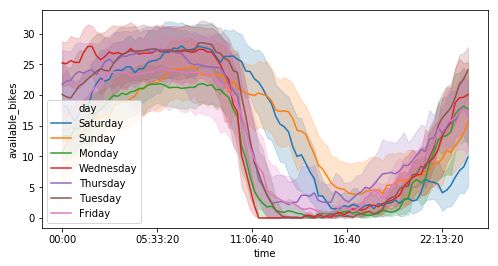

1 Ave & E 78 St


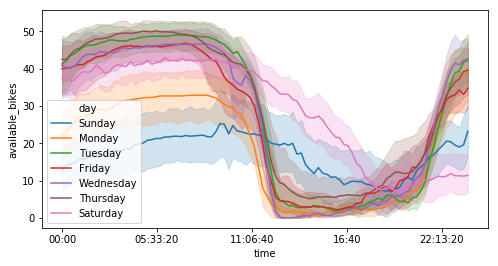

Vesey Pl & River Terrace


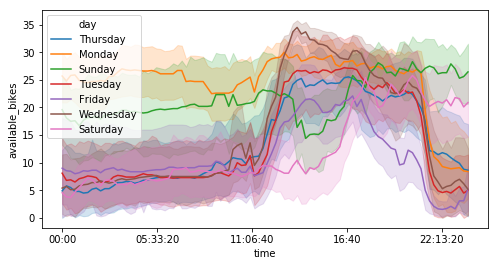

Vernon Blvd & 50 Ave


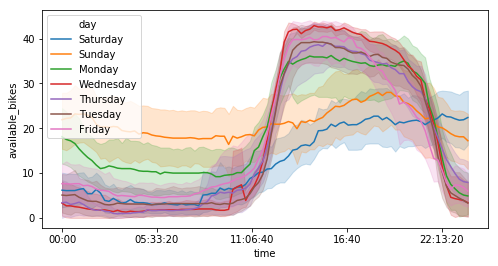

Fulton St & Adams St


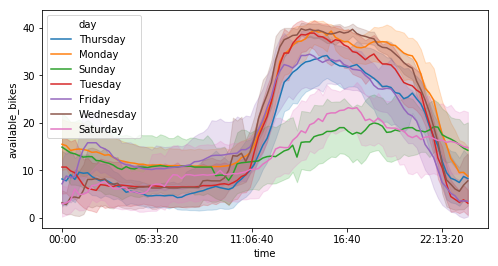

Clinton Ave & Myrtle Ave


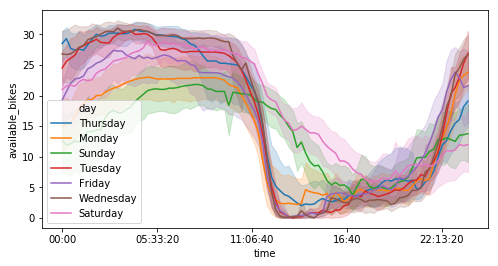

3 St & 7 Ave


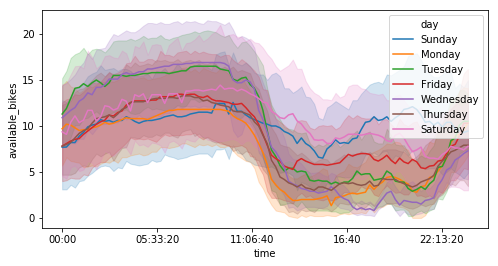

N 6 St & Bedford Ave


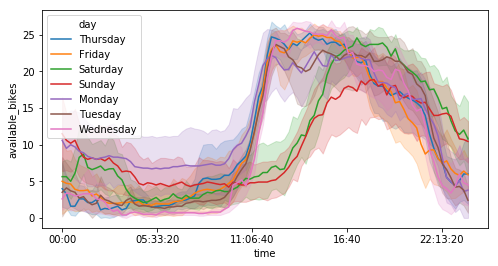

Underhill Ave & Pacific St


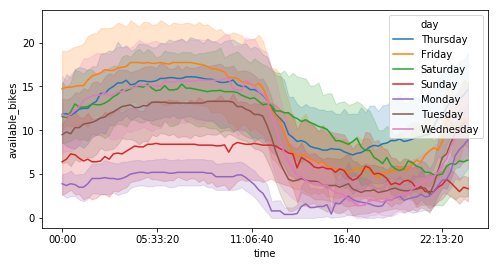

Classon Ave & St Marks Ave


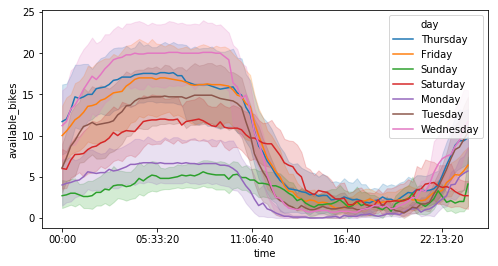

In [130]:
for station in df['station_name'].unique():
    fig, ax = plt.subplots(figsize=(8,4))
    sns.lineplot(x='time', y='available_bikes', data=df[df['station_name'] == station], hue='day')
    print(station)
    plt.show()

Auto-Generate README.md:

In [46]:
!jupyter nbconvert --output-dir='..' --to markdown analysis.ipynb --output README.md

[NbConvertApp] Converting notebook analysis.ipynb to markdown
[NbConvertApp] Writing 40866 bytes to ../README.md


[Powered by Dark Sky](https://darksky.net/poweredby/)